# Analysis

## env vars

In [7]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Get client ID and secret
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

## input data

In [10]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Set your credentials and the required scope
sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id,
        client_secret,
        redirect_uri="http://localhost:3000",
        scope="playlist-read-private",
    )
)

In [45]:
import pandas as pd

# Get user's playlists
playlists = sp.current_user_playlists()

# Get the tracks from the playlists in the "Rated" folder
tracks = []
for playlist in playlists['items']:
    if playlist['name'] in ["0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0"]:
        playlist_id = playlist['id']
        results = sp.playlist_tracks(playlist_id)
        for item in results['items']:
            track = item['track']
            # Get audio features for each track
            audio_features = sp.audio_features(track['id'])[0]
            # Merge track and its audio features
            track.update(audio_features)
            # Add rating to track
            track['rating'] = float(playlist['name'])  # Convert the playlist name to float and use it as the rating
            tracks.append(track)
        print(f"Playlist {playlist['name']} done")

# save tracks to csv
df = pd.DataFrame(tracks)
df.to_csv('tracks.csv')

Playlist 1.0 done
Playlist 1.5 done
Playlist 5.0 done
Playlist 2.5 done
Playlist 2.0 done
Playlist 0.5 done
Playlist 3.0 done
Playlist 4.5 done
Playlist 4.0 done
Playlist 3.5 done


## output data

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Load data
tracks_df = pd.read_csv('tracks.csv')

# Preprocess data
tracks_df = tracks_df.dropna()  # Drop rows with missing values
tracks_df = pd.get_dummies(tracks_df)  # One-hot encode categorical data

# Define your target variable
target = 'rating'  # Replace this with the column that represents the rating of a track

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    tracks_df.drop(target, axis=1), tracks_df[target], test_size=0.2
)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

## error

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions
predictions = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2 Score): {r2}')

Mean Absolute Error (MAE): 0.00776119402985074
Mean Squared Error (MSE): 0.0015305970149253707
R-squared (R2 Score): 0.9946342444357673


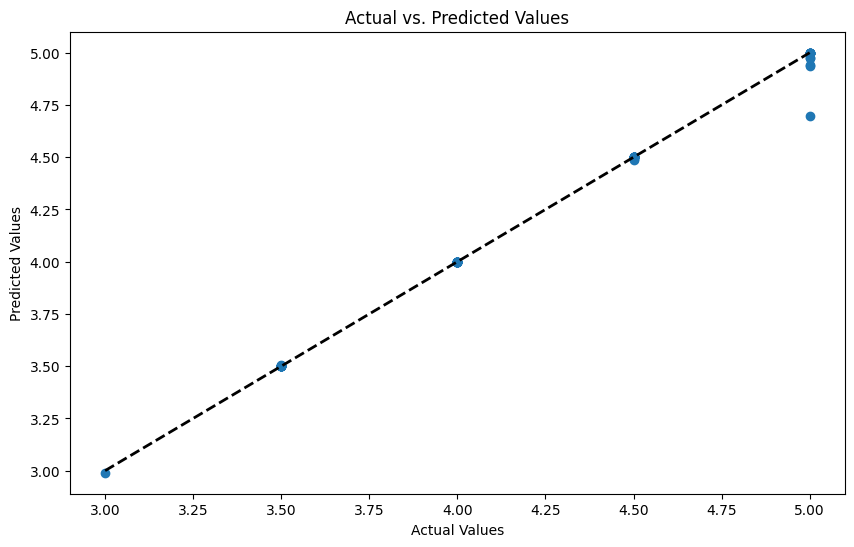

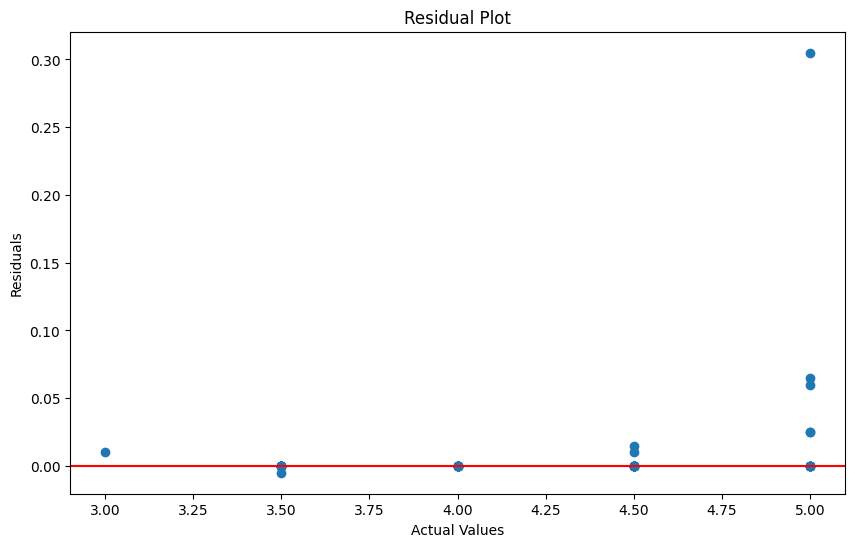

In [58]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(X_test)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add y=x line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# Residual plot
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Give Recommendations to Users Based on Their Preferences

## load unrated songs

## recommend songs

In [ ]:
# Load data of unrated songs
unrated_songs = pd.read_csv('unrated_songs.csv')

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs)  # One-hot encode categorical data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
for c in missing_cols:
    unrated_songs[c] = 0
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = model.predict(unrated_songs)

# Add predicted ratings to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings

# Recommend the top 10 songs with the highest predicted ratings
recommended_songs = unrated_songs.nlargest(10, 'predicted_rating')

print(recommended_songs)